# Source model uncertainty for Nath & Thingbaijam (2012)

OpenQuake isn't up to the task of enumerating $3^{222} \approx 0.83$ million googols of logic tree branches, so we will collapse all $m_{max}$ and $b$ variation for each areal zone into one discrete distribution.

In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
import os

import numpy as np
import pandas as pd
import toolbox as tb
import lxml.etree as et
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from StringIO import StringIO
from IPython.display import display

%autoreload 2
import source_model_tools as smt

%autoreload 2
import logic_tree_tools as ltt

import hmtk.sources as src
from openquake.hazardlib import tom, geo

from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser
from openquake.hazardlib.mfd.truncated_gr import TruncatedGRMFD

In [3]:
float(3**222)/10**106

0.8335248417898089

In [4]:
# key file names
areal_source_model_tsv = 'areal_source_model_no_twin.tsv'
min_mags = [4.5, 5.5]
smoothed_source_models_tsv = [
    'nath2012probabilistic_smoothed_source_model_mmin_%g.tsv' % min_mag
    for min_mag in min_mags]
source_tree_tsv = '../Logic Trees/areal_model_logic_tree.tsv'

In [5]:
# read areal model data from TSV file
source_zones_df = pd.read_csv(areal_source_model_tsv, sep='\t')
layer_ids = sorted(list(set(source_zones_df['layerid'])))

drop_columns = [
    'tectonic zone', 'concerns', 'zmax', 'zmin',
    'polygon coordinates', 'zoneid', 'mechanism', 'name', 'aspect ratio', 
    'smoothed N 4.5', 'smoothed N 5.5', 'smoothed a 4.5', 'smoothed a 5.5', 
    'smoothed lambda 4.5', 'smoothed lambda 5.5', 'areal lambda 4.5', 'areal lambda 5.5',
    'equiv a 4.5', 'equiv a 5.5',
]
display(pd.concat([source_zones_df.drop(drop_columns, axis=1).head(),
                   source_zones_df.drop(drop_columns, axis=1).tail()]))

,id,layerid,tectonic subregion,mmin,a,b,dip,mmax,msr,rake,region,stdb,stdmmax,strike
0,z1,1,subduction interface,4.5,5.20,1.05,73,8.0,StrasserInterface,30,Pamirs,0.07,0.4,202
1,z2,1,subduction interface,4.5,4.64,0.93,31,8.0,StrasserInterface,142,Pamirs,0.09,0.4,306
2,z3,1,active shallow crust strike-slip reverse,4.5,3.75,0.77,89,8.0,WC1994,33,Qaidam,0.05,0.4,59
3,z4,1,subduction interface,4.5,4.34,0.98,56,7.4,StrasserInterface,177,Kunlun Shan,0.08,0.4,309
4,z5,1,subduction interface,4.5,4.29,0.91,55,7.8,StrasserInterface,148,Pamirs,0.08,0.4,274
99,z9031,2,no seismicity,4.5,0.00,0.00,45,0.0,WC1994,90,Murray Ridge,0.00,0.0,0
100,z9081,2,no seismicity,4.5,0.00,0.00,45,0.0,WC1994,90,Himalayas,0.00,0.0,0
101,z9131,2,no seismicity,4.5,0.00,0.00,45,0.0,WC1994,90,Indo-Myanmar,0.00,0.0,0
102,z9151,2,no seismicity,4.5,0.00,0.00,45,0.0,WC1994,90,Bay of Bengal,0.00,0.0,0
103,z9171,2,no seismicity,4.5,0.00,0.00,45,0.0,WC1994,90,Bay of Bengal,0.00,0.0,0


In [6]:
source_tree_symbolic_df = ltt.read_tree_tsv(source_tree_tsv)        
display(source_tree_symbolic_df)

,uncertaintyType,applyToSources,uncertaintyModel,uncertaintyWeight
0,sourceModel,all,[areal_source_model.xml],[1]
1,maxMagGRAbsolute,areal_source_model.tsv,"[mmax - stdmmax, mmax, mmax + stdmmax]","[0.32, 0.36, 0.32]"
2,bGRRelative,areal_source_model.tsv,"[-stdb, 0, +stdb]","[0.32, 0.36, 0.32]"


In [7]:
collapsed_df, reduced_df, all_rates, all_weights, labels = \
    ltt.collapse_sources(source_zones_df, source_tree_symbolic_df)

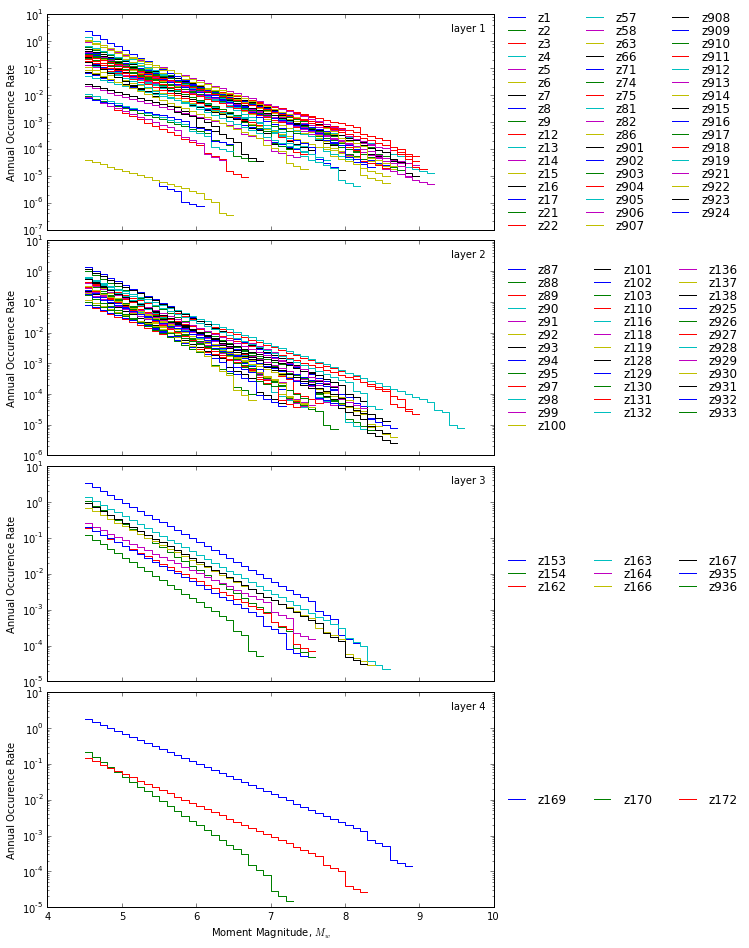

In [8]:
fig, axes = plt.subplots(len(layer_ids), 1, figsize=(8, 4*len(layer_ids)), sharex=True)
fig.subplots_adjust(hspace=0.05)
for layer_id, ax in zip(layer_ids, axes):
    fig.sca(ax)
    tb.annotate('layer %d' % layer_id)
    layer_df = collapsed_df[collapsed_df['layerid'] == layer_id]
    for _, zone in layer_df.iterrows():
        num_bins = zone['occurRates'].size
        mags = zone['mmin'] + zone['magBin']*np.arange(num_bins + 1)
        rates = zone['occurRates'][[0] + range(num_bins)]
        ax.step(mags, rates, label=zone['id'])
    ax.set_yscale('log')
    ax.set_ylabel('Annual Occurence Rate')
    ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', 
              frameon=False, labelspacing=0, ncol=3)

axes[-1].set_xlabel('Moment Magnitude, $M_w$')
fig.savefig('MeanOccurrenceRatesAllZones.pdf', transparent=True, bbox_inches='tight', pad_inches=0.1)

In [9]:
reduced_df

,uncertaintyType,applyToSources,uncertaintyModel,uncertaintyWeight
0,sourceModel,all,[areal_source_model.xml],[1]


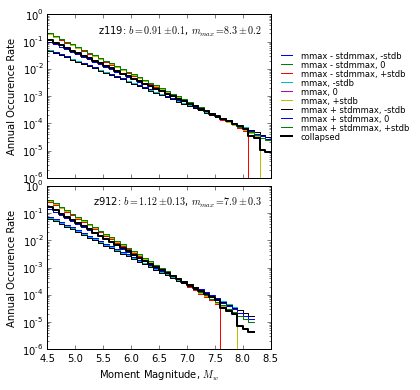

In [30]:
zoneids = ['z119','z912']
#zoneids = ['z1', 'z924', 'z93', 'z137', 'z913', 'z915', 'z132']
zones_rates = [rates for rates, zoneid in zip(all_rates, collapsed_df['id']) 
              if zoneid in zoneids]
zones_df = collapsed_df.loc[[zone['id'] in zoneids
           for _, zone in collapsed_df.iterrows()]]

fig, axes = plt.subplots(len(zoneids), 1, figsize=(4, 3*len(zoneids)), 
                         sharex=True)
fig.subplots_adjust(hspace=0.05)
for zone_rates, (_, zone), ax \
        in zip(zones_rates, zones_df.iterrows(), axes):
    fig.sca(ax)
    tb.annotate(r'%s: $b = %g \pm %g$, $m_{max} = %g \pm %g$' % 
                (zone['id'], zone['b'], zone['stdb'], zone['mmax'], zone['stdmmax']))
    num_bins = zone_rates.shape[0]
    mags = zone['mmin'] + zone['magBin']*np.arange(num_bins + 1)
    rates = zone_rates[[0] + range(num_bins), :]
    for rate, label in zip(rates.T, labels):
        ax.step(mags, rate.tolist(), label=label)
    ax.step(mags, zone['occurRates'][[0] + range(num_bins)], 
            linewidth=2, color='black', label='collapsed')
    ax.set_yscale('log')
    ax.set_ylabel('Annual Occurence Rate')

axes[0].legend(bbox_to_anchor=(1, 0.5), loc='center left', 
          frameon=False, labelspacing=0, fontsize='small')
axes[-1].set_xlabel('Moment Magnitude, $M_w$')

file_name = 'Mean_Occurrence_Rates_Zones_%s.pdf' % '_'.join([str(zone[1:]) for zone in zoneids])
fig.savefig(file_name, transparent=True, bbox_inches='tight', pad_inches=0.1)

In [11]:
def display_and_save(name, df):
    print name + ':'
    display(df)
    df.to_csv(name.replace(' ','_') + '.csv')

In [12]:
display_and_save('Selected zones of interest', 
                 zones_df.drop(drop_columns + ['occurRates'], axis=1))

Selected zones of interest:


,id,layerid,tectonic subregion,mmin,a,b,dip,magBin,mmax,msr,rake,region,stdb,stdmmax,strike
0,z1,1,subduction interface,4.5,5.20,1.05,73,0.1,8.0,StrasserInterface,30,Pamirs,0.07,0.4,202
33,z93,2,subduction interface,4.5,5.66,1.18,77,0.1,8.3,StrasserInterface,-2,Sulaiman,0.09,0.4,196
51,z132,2,subduction interface,4.5,4.40,0.87,14,0.1,9.4,StrasserInterface,79,Andaman-Sumatra,0.06,0.2,298
53,z137,2,subduction interface,4.5,7.33,1.57,89,0.1,6.5,StrasserInterface,-29,Andaman-Sumatra,0.16,0.3,282
77,z913,1,active shallow crust strike-slip reverse,4.5,4.35,0.93,88,0.1,8.8,WC1994,-175,Bangladesh,0.14,0.4,153
79,z915,1,active shallow crust normal,4.5,5.73,1.36,52,0.1,6.6,WC1994,-54,Bay of Bengal,0.14,0.3,234
87,z924,1,stable shallow crust,4.5,1.58,0.63,45,0.1,6.2,WC1994,90,Peninsular India,0.10,0.3,0


In [13]:
display_and_save('Top 5 b-value uncertainty', 
    collapsed_df.sort(columns='stdb', ascending=False).drop(drop_columns + ['occurRates'], axis=1).head())

Top 5 b-value uncertainty:


,id,layerid,tectonic subregion,mmin,a,b,dip,magBin,mmax,msr,rake,region,stdb,stdmmax,strike
53,z137,2,subduction interface,4.5,7.33,1.57,89,0.1,6.5,StrasserInterface,-29,Andaman-Sumatra,0.16,0.3,282
77,z913,1,active shallow crust strike-slip reverse,4.5,4.35,0.93,88,0.1,8.8,WC1994,-175,Bangladesh,0.14,0.4,153
79,z915,1,active shallow crust normal,4.5,5.73,1.36,52,0.1,6.6,WC1994,-54,Bay of Bengal,0.14,0.3,234
69,z905,1,active shallow crust normal,4.5,5.18,1.05,52,0.1,7.7,WC1994,-114,Tibetan plateau,0.13,0.4,159
76,z912,1,intraplate margin upper,4.5,4.84,1.12,40,0.1,7.9,WC1994,90,Shillong plateau,0.13,0.3,112


In [14]:
display_and_save('Top 3 mmax uncertainty', 
    collapsed_df.sort(columns='stdmmax', ascending=False).drop(drop_columns + ['occurRates'], axis=1).head(3))

Top 3 mmax uncertainty:


,id,layerid,tectonic subregion,mmin,a,b,dip,magBin,mmax,msr,rake,region,stdb,stdmmax,strike
0,z1,1,subduction interface,4.5,5.20,1.05,73,0.1,8.0,StrasserInterface,30,Pamirs,0.07,0.4,202
29,z89,2,subduction interface,4.5,5.29,1.11,68,0.1,7.3,StrasserInterface,94,Hindu Kush,0.06,0.4,340
32,z92,2,subduction interface,4.5,4.80,1.05,66,0.1,8.3,StrasserInterface,-5,Hindu Kush,0.10,0.4,194


In [15]:
display_and_save('Top 3 mmax', 
    collapsed_df.sort(columns='mmax', ascending=False).drop(drop_columns + ['occurRates'], axis=1).head(3))

Top 3 mmax:


,id,layerid,tectonic subregion,mmin,a,b,dip,magBin,mmax,msr,rake,region,stdb,stdmmax,strike
51,z132,2,subduction interface,4.5,4.40,0.87,14,0.1,9.4,StrasserInterface,79,Andaman-Sumatra,0.06,0.2,298
82,z918,1,subduction interface,4.5,3.89,0.82,25,0.1,8.9,StrasserInterface,108,Andaman-Sumatra,0.07,0.2,337
43,z110,2,subduction interface,4.5,3.58,0.78,23,0.1,8.8,StrasserInterface,82,Himalayas,0.06,0.2,290


In [16]:
display_and_save('Bottom 3 mmax', 
    collapsed_df.sort(columns='mmax', ascending=True).drop(drop_columns + ['occurRates'], axis=1).head(3))

Bottom 3 mmax:


,id,layerid,tectonic subregion,mmin,a,b,dip,magBin,mmax,msr,rake,region,stdb,stdmmax,strike
21,z71,1,no seismicity,4.5,0.00,0.81,45,0.1,5.8,WC1994,90,Bay of Bengal & Arabian Sea,0.05,0.3,0
86,z923,1,stable shallow crust,4.5,2.51,0.73,45,0.1,6.0,WC1994,90,Peninsular India,0.06,0.3,0
25,z82,1,stable shallow crust,4.5,3.14,1.01,66,0.1,6.1,WC1994,64,Peninsular India,0.13,0.3,51


In [17]:
display_and_save('Bottom 5 a-value', 
    collapsed_df.sort(columns='a', ascending=True).drop(drop_columns + ['occurRates'], axis=1).head())

Bottom 5 a-value:


,id,layerid,tectonic subregion,mmin,a,b,dip,magBin,mmax,msr,rake,region,stdb,stdmmax,strike
21,z71,1,no seismicity,4.5,0.00,0.81,45,0.1,5.8,WC1994,90,Bay of Bengal & Arabian Sea,0.05,0.3,0
26,z86,1,no seismicity,4.5,0.00,0.81,45,0.1,6.3,WC1994,90,"Sri Lanka, Laccadive Sea",0.05,0.2,0
87,z924,1,stable shallow crust,4.5,1.58,0.63,45,0.1,6.2,WC1994,90,Peninsular India,0.10,0.3,0
86,z923,1,stable shallow crust,4.5,2.51,0.73,45,0.1,6.0,WC1994,90,Peninsular India,0.06,0.3,0
84,z921,1,stable shallow crust,4.5,2.53,0.76,26,0.1,7.0,WC1994,129,Peninsular India,0.07,0.4,283


In [18]:
display_and_save('Top 3 a-value', 
    collapsed_df.sort(columns='a', ascending=False).drop(drop_columns + ['occurRates'], axis=1).head(3))

Top 3 a-value:


,id,layerid,tectonic subregion,mmin,a,b,dip,magBin,mmax,msr,rake,region,stdb,stdmmax,strike
53,z137,2,subduction interface,4.5,7.33,1.57,89,0.1,6.5,StrasserInterface,-29,Andaman-Sumatra,0.16,0.3,282
73,z909,1,active shallow crust normal,4.5,7.08,1.37,33,0.1,7.6,WC1994,-82,Tibetan plateau,0.12,0.3,268
17,z57,1,active shallow crust normal,4.5,6.79,1.35,48,0.1,7.2,WC1994,-77,Andaman-Sumatra,0.10,0.4,244


In [19]:
display_and_save('Top 3 b-value', 
    collapsed_df.sort(columns='b', ascending=False).drop(drop_columns + ['occurRates'], axis=1).head(3))

Top 3 b-value:


,id,layerid,tectonic subregion,mmin,a,b,dip,magBin,mmax,msr,rake,region,stdb,stdmmax,strike
53,z137,2,subduction interface,4.5,7.33,1.57,89,0.1,6.5,StrasserInterface,-29,Andaman-Sumatra,0.16,0.3,282
73,z909,1,active shallow crust normal,4.5,7.08,1.37,33,0.1,7.6,WC1994,-82,Tibetan plateau,0.12,0.3,268
79,z915,1,active shallow crust normal,4.5,5.73,1.36,52,0.1,6.6,WC1994,-54,Bay of Bengal,0.14,0.3,234


In [20]:
display_and_save('Bottom 3 b-value', 
    collapsed_df.sort(columns='b', ascending=True).drop(drop_columns + ['occurRates'], axis=1).head(3))

Bottom 3 b-value:


,id,layerid,tectonic subregion,mmin,a,b,dip,magBin,mmax,msr,rake,region,stdb,stdmmax,strike
87,z924,1,stable shallow crust,4.5,1.58,0.63,45,0.1,6.2,WC1994,90,Peninsular India,0.10,0.3,0
83,z919,1,stable shallow crust,4.5,2.73,0.72,61,0.1,7.2,WC1994,123,Peninsular India,0.10,0.3,290
11,z14,1,subduction interface,4.5,3.12,0.72,69,0.1,8.6,StrasserInterface,-30,Makran,0.09,0.4,228


In [21]:
twinned_df = smt.twin_source_by_magnitude(collapsed_df)

In [22]:
display(collapsed_df[collapsed_df['zoneid'] == 1].drop(drop_columns + ['region'], axis=1))
collapsed_df[collapsed_df['zoneid'] == 1]['occurRates'].values

,id,layerid,tectonic subregion,mmin,a,b,dip,magBin,mmax,msr,occurRates,rake,stdb,stdmmax,strike
0,z1,1,subduction interface,4.5,5.2,1.05,73,0.1,8,StrasserInterface,"[0.67435, 0.52736, 0.41247, 0.32266, 0.25245, ...",30,0.07,0.4,202


array([ array([  6.74350000e-01,   5.27360000e-01,   4.12470000e-01,
         3.22660000e-01,   2.52450000e-01,   1.97540000e-01,
         1.54600000e-01,   1.21020000e-01,   9.47430000e-02,
         7.41850000e-02,   5.80960000e-02,   4.55050000e-02,
         3.56480000e-02,   2.79300000e-02,   2.18870000e-02,
         1.71550000e-02,   1.34480000e-02,   1.05430000e-02,
         8.26750000e-03,   6.48410000e-03,   5.08620000e-03,
         3.99030000e-03,   3.13110000e-03,   2.45730000e-03,
         1.92880000e-03,   1.51420000e-03,   1.18900000e-03,
         9.33730000e-04,   7.33400000e-04,   5.76150000e-04,
         4.52690000e-04,   2.41430000e-04,   1.89700000e-04,
         1.49080000e-04,   1.17180000e-04,   4.32340000e-05,
         3.39820000e-05,   2.67150000e-05,   2.10050000e-05])], dtype=object)

In [23]:
display(twinned_df[(twinned_df['zoneid'] == '1') | (twinned_df['zoneid'] == '1m')].drop(drop_columns + ['region'], axis=1))
display(twinned_df[twinned_df['zoneid'] == '1']['occurRates'].values)
display(twinned_df[twinned_df['zoneid'] == '1m']['occurRates'].values)

,id,layerid,tectonic subregion,mmin,a,b,dip,magBin,mmax,msr,occurRates,rake,stdb,stdmmax,strike
0,z1,1,subduction interface,4.5,5.2,1.05,73,0.1,7.5,StrasserInterface,"[0.67435, 0.52736, 0.41247, 0.32266, 0.25245, ...",30,0.07,0.4,202
99,z1,1,subduction interface megathrust,7.5,5.2,1.05,73,0.1,8.0,StrasserInterface,"[0.00045269, 0.00024143, 0.0001897, 0.00014908...",30,0.07,0.4,202


array([ array([  6.74350000e-01,   5.27360000e-01,   4.12470000e-01,
         3.22660000e-01,   2.52450000e-01,   1.97540000e-01,
         1.54600000e-01,   1.21020000e-01,   9.47430000e-02,
         7.41850000e-02,   5.80960000e-02,   4.55050000e-02,
         3.56480000e-02,   2.79300000e-02,   2.18870000e-02,
         1.71550000e-02,   1.34480000e-02,   1.05430000e-02,
         8.26750000e-03,   6.48410000e-03,   5.08620000e-03,
         3.99030000e-03,   3.13110000e-03,   2.45730000e-03,
         1.92880000e-03,   1.51420000e-03,   1.18900000e-03,
         9.33730000e-04,   7.33400000e-04,   5.76150000e-04])], dtype=object)

array([ array([  4.52690000e-04,   2.41430000e-04,   1.89700000e-04,
         1.49080000e-04,   1.17180000e-04,   4.32340000e-05,
         3.39820000e-05,   2.67150000e-05,   2.10050000e-05])], dtype=object)

In [24]:
# write result to NRML
areal_source_list = smt.source_df_to_list(smt.sort_and_reindex(smt.add_name_id(twinned_df)))
areal_source_model = src.source_model.mtkSourceModel(
    identifier='areal', 
    name='areal collapsed', 
    sources=areal_source_list)
areal_source_model.serialise_to_nrml('areal_collapsed.xml')

In [25]:
for smoothed_source_model_tsv, min_mag in zip(smoothed_source_models_tsv, min_mags):
    smoothed_source_df = pd.read_csv(smoothed_source_model_tsv, sep='\t')
    smoothed_collapsed_df = ltt.collapse_sources(smoothed_source_df, source_tree_symbolic_df)[0]
    smoothed_source_list = smt.source_df_to_list(smt.add_name_id(smt.twin_source_by_magnitude(smoothed_collapsed_df)))
    
    areal_source_model = src.source_model.mtkSourceModel(
        identifier=str(min_mag), 
        name='nath2012probabilistic smoothed collapsed', 
        sources=smoothed_source_list)
    areal_source_model.serialise_to_nrml('nath2012probabilistic_smoothed_collapsed_mmin%g.xml' % min_mag)